In [1]:
import gseapy as gp
from gseapy import Msigdb, dotplot
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
import igraph as ig

### MSigDB GSEA for features

As there are not very many features these hits do not come up as significant but the purpose is just to identify terms associated with the main predictors of the model. 

In [2]:
features = pd.read_csv('/lustre/scratch125/casm/team215mg/pg21_rotation/feature_list.tsv', sep = '\t')
features.drop(labels = 'Unnamed: 0', axis = 1, inplace = True)

In [3]:
features['columns'] = features['columns'].str.replace("_delta", "")
features['columns'] = features['columns'].str.replace("_", ".")
features

In [4]:
enr = gp.enrichr(gene_list = features['columns'],
                 gene_sets = 'MSigDB_Hallmark_2020',
                 organism = 'human',
                 outdir = None)

In [5]:
enr.results

### GSEA against 3CA, MSigDB Hallmark, and MSigDB Cell Type

First creates the database and then loop through coefficients file to generate and save GSEA plot for every cell type/time point for drug combinations. Then counts occurrence of all terms identified. Lastly plots can be generated showing DE trajectory for a specified gene, this has to be manually specified as a parameter.

In [6]:
msig = Msigdb()

h_all = msig.get_gmt(category = 'h.all', dbver = '2024.1.Hs')
c4_3ca = msig.get_gmt(category = 'c4.3ca', dbver = '2024.1.Hs')
c8_all = msig.get_gmt(category = 'c8.all', dbver = '2024.1.Hs')

gmt = {**h_all, **c4_3ca, **c8_all}

In [16]:
timepoints = [24, 48, 72]

for time in timepoints: 
    coeff = pd.read_csv(f'/lustre/scratch125/casm/team215mg/pg21_rotation/Coefficients_CellDrift/selection_rep_4/Contrast_Coefficients_time_{time}.txt', sep = '\t')
    coeff['cell_type'] = coeff['cell_type'].str.split(',', n = 1).str.get(-1).str.split("'").str.get(-2)
    coeff['perturbation'] = coeff['perturbation'].str.split(',', n = 1).str.get(0).str.split("'").str.get(-2)
    coeff['gene'] = coeff['gene'].str.replace("_", ".")
    for state in np.unique(coeff['cell_type']):
        subset = coeff[coeff['cell_type'] == state]
        degs = pd.DataFrame()
        degs['genes'] = np.unique(subset[subset['p_fdr'] <= 0.05]['gene'])
        enr = gp.enrich(gene_list = degs['genes'], gene_sets = gmt, outdir = None, background = None)
        enr.results[enr.results['Adjusted P-value'] < 0.05].to_csv(f'deg_enrichments_{state}_{time}.tsv', sep = '\t')
        ax = dotplot(enr.res2d, title = 'GSEA', cmap = 'viridis_r', size = 15, figsize = (3,5),
             ofname = f'top_terms_{state}_{time}.svg')


In [8]:
ax = dotplot(enr.results, title = 'GSEA', cmap = 'viridis_r', size = 20, figsize = (3,5),
             ofname = None, top_term = 10)

In [9]:
timepoints = [24, 48, 72]
all_enr = {}
term_list = []

for time in timepoints: 
    coeff = pd.read_csv(f'/lustre/scratch125/casm/team215mg/pg21_rotation/Coefficients_CellDrift/selection_rep_1/Contrast_Coefficients_time_{time}.txt', sep = '\t')
    coeff['cell_type'] = coeff['cell_type'].str.split(',', n = 1).str.get(-1).str.split("'").str.get(-2)
    coeff['perturbation'] = coeff['perturbation'].str.split(',', n = 1).str.get(0).str.split("'").str.get(-2)
    coeff['gene'] = coeff['gene'].str.replace("_", ".")
    for state in np.unique(coeff['cell_type']):
        subset = coeff[coeff['cell_type'] == state]
        degs = pd.DataFrame()
        degs['genes'] = np.unique(subset[subset['p_fdr'] <= 0.05]['gene'])
        enr = gp.enrich(gene_list = degs['genes'], gene_sets = gmt, outdir = None, background = None)
        all_enr[f'{state}_{time}']= enr.results[enr.results['Adjusted P-value'] < 0.05]
        term_list.extend(enr.results[enr.results['Adjusted P-value'] < 0.05]['Term'])


In [10]:
Counter(term_list)

In [11]:
df_terms = pd.DataFrame()
term = 'GAVISH_3CA_MALIGNANT_METAPROGRAM_5_STRESS'

for i in range(len(all_enr)):
    state = list(all_enr.keys())[i]
    row = all_enr[state][all_enr[state]['Term'] == term]
    row['State'] = state.split('_')[0]
    row['Time'] = state.split('_')[1]
    df_terms = pd.concat([df_terms, row])

In [10]:
ax = sns.scatterplot(x = df_terms['Time'], y = df_terms['Combined Score'], hue = df_terms['State'], zorder = 1)
sns.lineplot(x = df_terms['Time'], y = df_terms['Combined Score'], hue = df_terms['State'], zorder = 2)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [24]:
timepoints = [24, 48, 72]
df_gene = pd.DataFrame()
geneofinterest = 'PROX1'

for time in timepoints: 
    coeff = pd.read_csv(f'/lustre/scratch125/casm/team215mg/pg21_rotation/Coefficients_CellDrift/selection_rep_4/Contrast_Coefficients_time_{time}.txt', sep = '\t')
    coeff['cell_type'] = coeff['cell_type'].str.split(',', n = 1).str.get(-1).str.split("'").str.get(-2)
    coeff['perturbation'] = coeff['perturbation'].str.split(',', n = 1).str.get(0).str.split("'").str.get(-2)
    coeff['gene'] = coeff['gene'].str.replace("_", ".")
    coeff['time'] = time
    coeff = coeff[(coeff['perturbation'] == 'MRTX1133_SHP099')]
    df_gene = pd.concat([df_gene, coeff[coeff['gene'] == geneofinterest]])

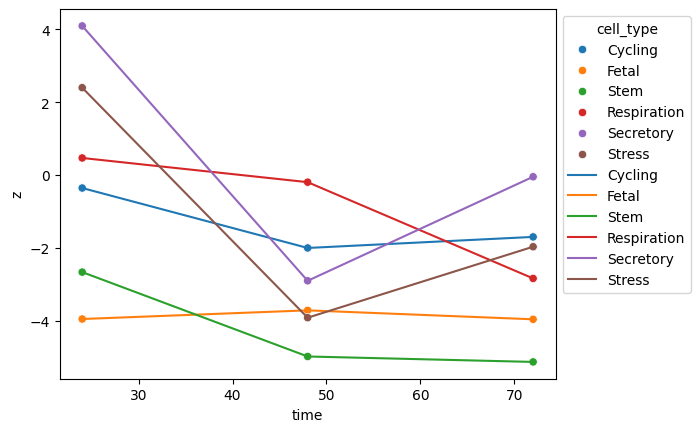

In [25]:
ax = sns.scatterplot(x = df_gene['time'], y = df_gene['z'], hue = df_gene['cell_type'], zorder = 1)
sns.lineplot(x = df_gene['time'], y = df_gene['z'], hue = df_gene['cell_type'], zorder = 2)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#plt.savefig('AC007179_2.svg', bbox_inches = 'tight')

In [2]:
coefficients = pd.DataFrame()
timepoints = ['24', '48', '72']

for rep in range(1,11):
    for time in timepoints:
        temp_coeff = pd.read_csv(f'/lustre/scratch125/casm/team215mg/pg21_rotation/Coefficients_CellDrift/selection_rep_{rep}/Contrast_Coefficients_time_{time}.txt', sep = '\t')
        temp_coeff['contrast'] = temp_coeff['contrast'] + f'_{rep}'
        temp_coeff['time'] = time
        coefficients = pd.concat([coefficients, temp_coeff], ignore_index = True)

coefficients['cell_type'] = coefficients['cell_type'].str.split(',', n = 1).str.get(-1).str.split("'").str.get(-2)
coefficients['perturbation'] = coefficients['perturbation'].str.split(',', n = 1).str.get(0).str.split("'").str.get(-2)

coefficients = coefficients[(coefficients['perturbation'] == 'MRTX1133_SHP099') | (coefficients['perturbation'] == 'MRTX1133_afatinib')]

coefficients

,contrast,cell_type,perturbation,mean,lci,uci,SE,z,p,p_fdr,pts_contrast,pts_reference,gene,time
1,Cycling_MRTX1133_SHP099-Cycling_DMSO_1,Cycling,MRTX1133_SHP099,1.1908,1.8376,0.5441,0.3300,3.6088,0.0003,0.002662,0.219178,0.130000,ABAT,24
2,Cycling_MRTX1133_afatinib-Cycling_DMSO_1,Cycling,MRTX1133_afatinib,1.2289,1.9590,0.4988,0.3725,3.2991,0.0010,0.006495,0.200000,0.130000,ABAT,24
6,Fetal_MRTX1133_SHP099-Fetal_DMSO_1,Fetal,MRTX1133_SHP099,-0.2991,0.0966,-0.6948,0.2019,-1.4813,0.1385,0.271822,0.490000,0.360000,ABAT,24
7,Fetal_MRTX1133_afatinib-Fetal_DMSO_1,Fetal,MRTX1133_afatinib,-0.3774,0.0459,-0.8008,0.2160,-1.7474,0.0806,0.185321,0.350000,0.360000,ABAT,24
11,Stem_MRTX1133_SHP099-Stem_DMSO_1,Stem,MRTX1133_SHP099,0.7952,1.3217,0.2686,0.2686,2.9600,0.0031,0.015878,0.280000,0.196667,ABAT,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808187,Respiration_MRTX1133_afatinib-Respiration_DMSO_10,Respiration,MRTX1133_afatinib,0.0686,232860.8178,-232860.6806,118808.6878,0.0000,1.0000,1.000000,0.000000,0.000000,ZNF831,72
808191,Secretory_MRTX1133_SHP099-Secretory_DMSO_10,Secretory,MRTX1133_SHP099,0.0557,281932.6542,-281932.5428,143845.8057,0.0000,1.0000,1.000000,0.000000,0.000000,ZNF831,72
808192,Secretory_MRTX1133_afatinib-Secretory_DMSO_10,Secretory,MRTX1133_afatinib,-0.0390,691627.7387,-691627.8166,352877.7993,-0.0000,1.0000,1.000000,0.000000,0.000000,ZNF831,72
808196,Stress_MRTX1133_SHP099-Stress_DMSO_10,Stress,MRTX1133_SHP099,1.8791,4.2465,-0.4883,1.2079,1.5557,0.1198,1.000000,0.010000,0.003333,ZNF831,72


In [72]:
df_gene = coefficients[(coefficients['gene'] == 'PROX1')]

In [73]:
df_gene = df_gene.groupby(['time', 'cell_type']).mean('z')

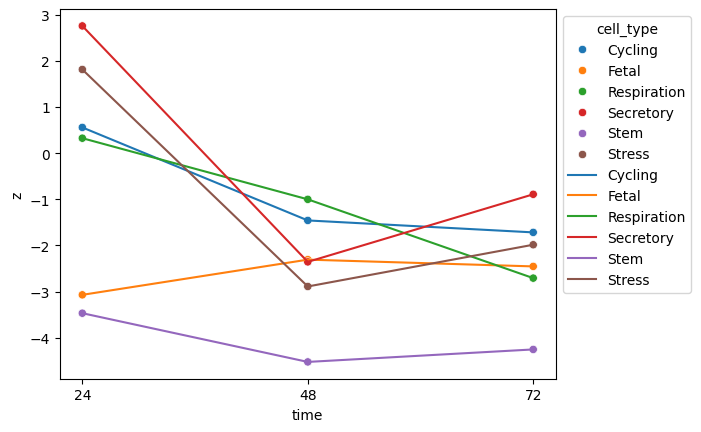

In [74]:
ax = sns.scatterplot(x = df_gene.index.get_level_values(0), y = df_gene['z'], hue = df_gene.index.get_level_values(1), zorder = 1)
sns.lineplot(x = df_gene.index.get_level_values(0), y = df_gene['z'], hue = df_gene.index.get_level_values(1), zorder = 2)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig('PROX1.svg', bbox_inches = 'tight')

In [75]:
coeff_sig = coefficients[coefficients['p_fdr'] < 0.05]

In [77]:
timepoints = ['24', '48', '72']

for time in timepoints:
    for state in np.unique(coeff_sig['cell_type']):
        degs = pd.DataFrame()
        subset = coeff_sig[(coeff_sig['cell_type'] == state) & (coeff_sig['time'] == time)] 
        degs['genes'] = np.unique(subset['gene'])
        enr = gp.enrich(gene_list = degs['genes'], gene_sets = gmt, outdir = None, background = None)
        enr.results[enr.results['Adjusted P-value'] < 0.05].to_csv(f'deg_enrichments_{state}_{time}.tsv', sep = '\t')
        ax = dotplot(enr.res2d, title = 'GSEA', cmap = 'viridis_r', size = 15, figsize = (3,5),
             ofname = f'top_terms_{state}_{time}.pdf')

In [22]:
np.unique(coeff_sig[(coeff_sig['cell_type'] == 'Fetal') & (coeff_sig['time'] == '72')]['gene'])

array(['ABCA1', 'ABCB1', 'ABHD2', 'ABHD6', 'ABTB2', 'AC002451_1',
       'AC003958_2', 'AC005062_1', 'AC007099_1', 'AC007100_1',
       'AC007179_2', 'AC007277_1', 'AC007368_1', 'AC007405_1',
       'AC010343_3', 'AC011287_1', 'AC011586_2', 'AC012405_1',
       'AC012501_2', 'AC013287_1', 'AC019211_1', 'AC022509_1',
       'AC026167_1', 'AC068587_4', 'AC073050_1', 'AC073114_1',
       'AC073365_1', 'AC087857_1', 'AC093083_1', 'AC093866_1',
       'AC098617_1', 'AC099560_1', 'AC104823_1', 'AC105450_1',
       'AC106795_2', 'AC106795_3', 'AC114811_2', 'AC139493_2',
       'AC141930_1', 'ACER2', 'AGMO', 'AGR2', 'AHRR', 'AL008633_1',
       'AL050309_1', 'AL136962_1', 'AL139815_1', 'AL353138_1', 'ALCAM',
       'ALDH1A1', 'ALDH3A1', 'AMIGO2', 'AMOT', 'ANKEF1', 'ANLN', 'ANXA1',
       'ANXA3', 'AOAH', 'APLF', 'APOLD1', 'AREG', 'ARHGAP42', 'ARHGEF38',
       'ASAH2', 'ASB4', 'ASPM', 'ATAD2', 'ATF3', 'ATP10B', 'ATP5F1E',
       'ATP5IF1', 'ATP5MC1', 'ATP5MD', 'ATP5ME', 'ATP5MPL', 'BARD1',
   

In [23]:
coeff_sig[(coeff_sig['cell_type'] == 'Fetal') & (coeff_sig['time'] == '72')]

,contrast,cell_type,perturbation,mean,lci,uci,SE,z,p,p_fdr,pts_contrast,pts_reference,gene,time
53977,Fetal_MRTX1133_afatinib-Fetal_DMSO_1,Fetal,MRTX1133_afatinib,0.6473,1.0764,0.2181,0.2190,2.9559,0.0031,0.008528,0.37,0.186667,ABCB1,72
54006,Fetal_MRTX1133_SHP099-Fetal_DMSO_1,Fetal,MRTX1133_SHP099,-0.6735,-0.3652,-0.9818,0.1573,-4.2822,0.0000,0.000000,0.70,0.813333,ABHD2,72
54007,Fetal_MRTX1133_afatinib-Fetal_DMSO_1,Fetal,MRTX1133_afatinib,-0.4963,-0.1920,-0.8005,0.1552,-3.1969,0.0014,0.007805,0.71,0.813333,ABHD2,72
54036,Fetal_MRTX1133_SHP099-Fetal_DMSO_1,Fetal,MRTX1133_SHP099,0.7038,1.0820,0.3256,0.1930,3.6472,0.0003,0.002625,0.55,0.246667,ABHD6,72
54037,Fetal_MRTX1133_afatinib-Fetal_DMSO_1,Fetal,MRTX1133_afatinib,0.7527,1.1354,0.3699,0.1953,3.8541,0.0001,0.001033,0.50,0.246667,ABHD6,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807907,Fetal_MRTX1133_afatinib-Fetal_DMSO_10,Fetal,MRTX1133_afatinib,1.7665,2.2376,1.2954,0.2404,7.3489,0.0000,0.000000,0.32,0.093333,ZFPM2,72
807936,Fetal_MRTX1133_SHP099-Fetal_DMSO_10,Fetal,MRTX1133_SHP099,0.6516,0.9941,0.3091,0.1748,3.7286,0.0002,0.001416,0.65,0.400000,ZHX2,72
807937,Fetal_MRTX1133_afatinib-Fetal_DMSO_10,Fetal,MRTX1133_afatinib,0.6644,1.0190,0.3098,0.1809,3.6726,0.0002,0.001416,0.58,0.400000,ZHX2,72
808116,Fetal_MRTX1133_SHP099-Fetal_DMSO_10,Fetal,MRTX1133_SHP099,0.5395,0.8974,0.1815,0.1826,2.9535,0.0031,0.011224,0.62,0.300000,ZNF704,72


In [69]:
degs = pd.DataFrame()

sig_72 = coeff_sig[(coeff_sig['contrast'] == 'Fetal_MRTX1133_afatinib-Fetal_DMSO_1') | (coeff_sig['contrast'] == 'Fetal_MRTX1133_SHP099-Fetal_DMSO_1')]

degs['genes'] = np.unique(sig_72[sig_72['time'] == '72']['gene'])
enr = gp.enrich(gene_list = degs['genes'], gene_sets = gmt, outdir = None, background = None)
ax = dotplot(enr.res2d, title = 'GSEA', cmap = 'viridis_r', size = 15, figsize = (3,5),
             ofname = f'top_terms_Fetal_72.svg')

In [65]:
coeff = pd.read_csv(f'/lustre/scratch125/casm/team215mg/pg21_rotation/Coefficients_CellDrift/selection_rep_10/Contrast_Coefficients_time_{time}.txt', sep = '\t')
coeff['cell_type'] = coeff['cell_type'].str.split(',', n = 1).str.get(-1).str.split("'").str.get(-2)
coeff['perturbation'] = coeff['perturbation'].str.split(',', n = 1).str.get(0).str.split("'").str.get(-2)
coeff['gene'] = coeff['gene'].str.replace("_", ".")

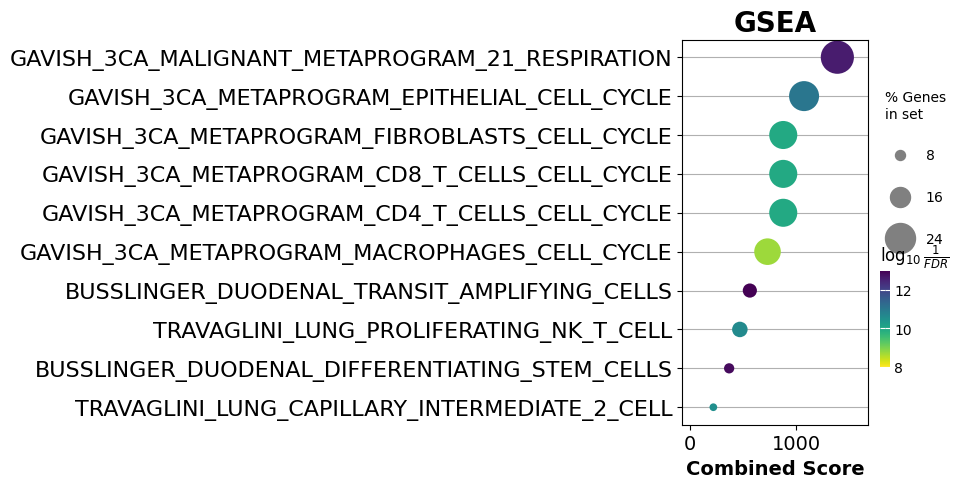

In [66]:
degs = pd.DataFrame()

coeff = coeff[(coeff['p_fdr'] < 0.05) & (coeff['cell_type'] == 'Fetal')]
degs['genes'] = np.unique(coeff[(coeff['perturbation'] == 'MRTX1133_SHP099') | (coeff['perturbation'] == 'MRTX1133_afatinib')]['gene'])

enr = gp.enrich(gene_list = degs['genes'], gene_sets = gmt, outdir = None, background = None)
ax = dotplot(enr.res2d, title = 'GSEA', cmap = 'viridis_r', size = 15, figsize = (3,5))

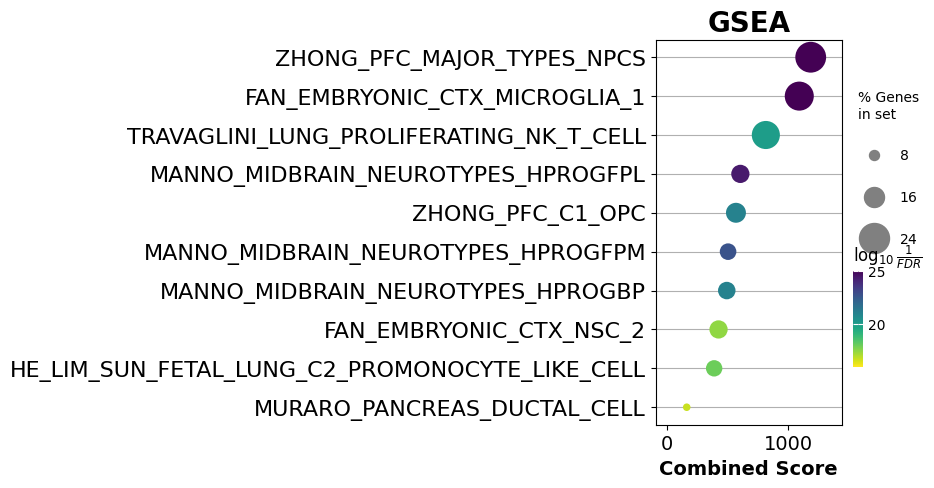

In [68]:
degs = pd.DataFrame()

sig_72 = coeff_sig[(coeff_sig['perturbation'] == 'MRTX1133_afatinib') | (coeff_sig['perturbation'] == 'MRTX1133_SHP099')]

degs['genes'] = np.unique(sig_72[(sig_72['cell_type'] == 'Fetal') & (sig_72['time'] == '72')]['gene'])
enr = gp.enrich(gene_list = degs['genes'], gene_sets = gmt, outdir = None, background = None)
ax = dotplot(enr.res2d, title = 'GSEA', cmap = 'viridis_r', size = 15, figsize = (3,5))